```{eval-rst}
.. include:: sinebow.rst

```

{sinebow25}`Cell diameter`
==================================

The idea of an average cell diameter sounds intuitive, but the standard implementation of this idea fails to capture that intuition. 
The go-to method (adopted in Cellpose) is to calculate the cell diameter as the diameter of the circle of equivalent area. As I will demonstrate, 
this fails for anisotropic (non-circular) cells. As an alternative, I devised the following simple diameter metric: 

```python
diameter = 2*(dimension+1)*np.mean(distance_field)
```

Because the distance field represents the distance to the *closest* boundary point, it naturally captures the intrinsic 'thickness' of a region (in any dimension). Averaging the field over the region 
(the first moment of the distribution) distills this information into a number that is intuitively proportional to the thickness of the region. For example, if a region is made up of a bungle of many 
thin fragments, its mean distance is far smaller than the mean distance of the circle of equivalent area. But to call it a 'diameter', I wanted this metric to match the diameter of a sphere in any dimension. 
So, by calculating the average of distance field of an n-sphere, we get the above expression for the the diameter of an n-sphere given the average of the distance field over the volume. 

{header-2}`Example cells`
-------------------------
Filamenting bacterial cells often exhibit constant width but increasing length. This dataset comes from the deletion of the essential gene *ftsN* in *Acinetobacter baylyi*. 

In [2]:
%load_ext autoreload
%autoreload 2

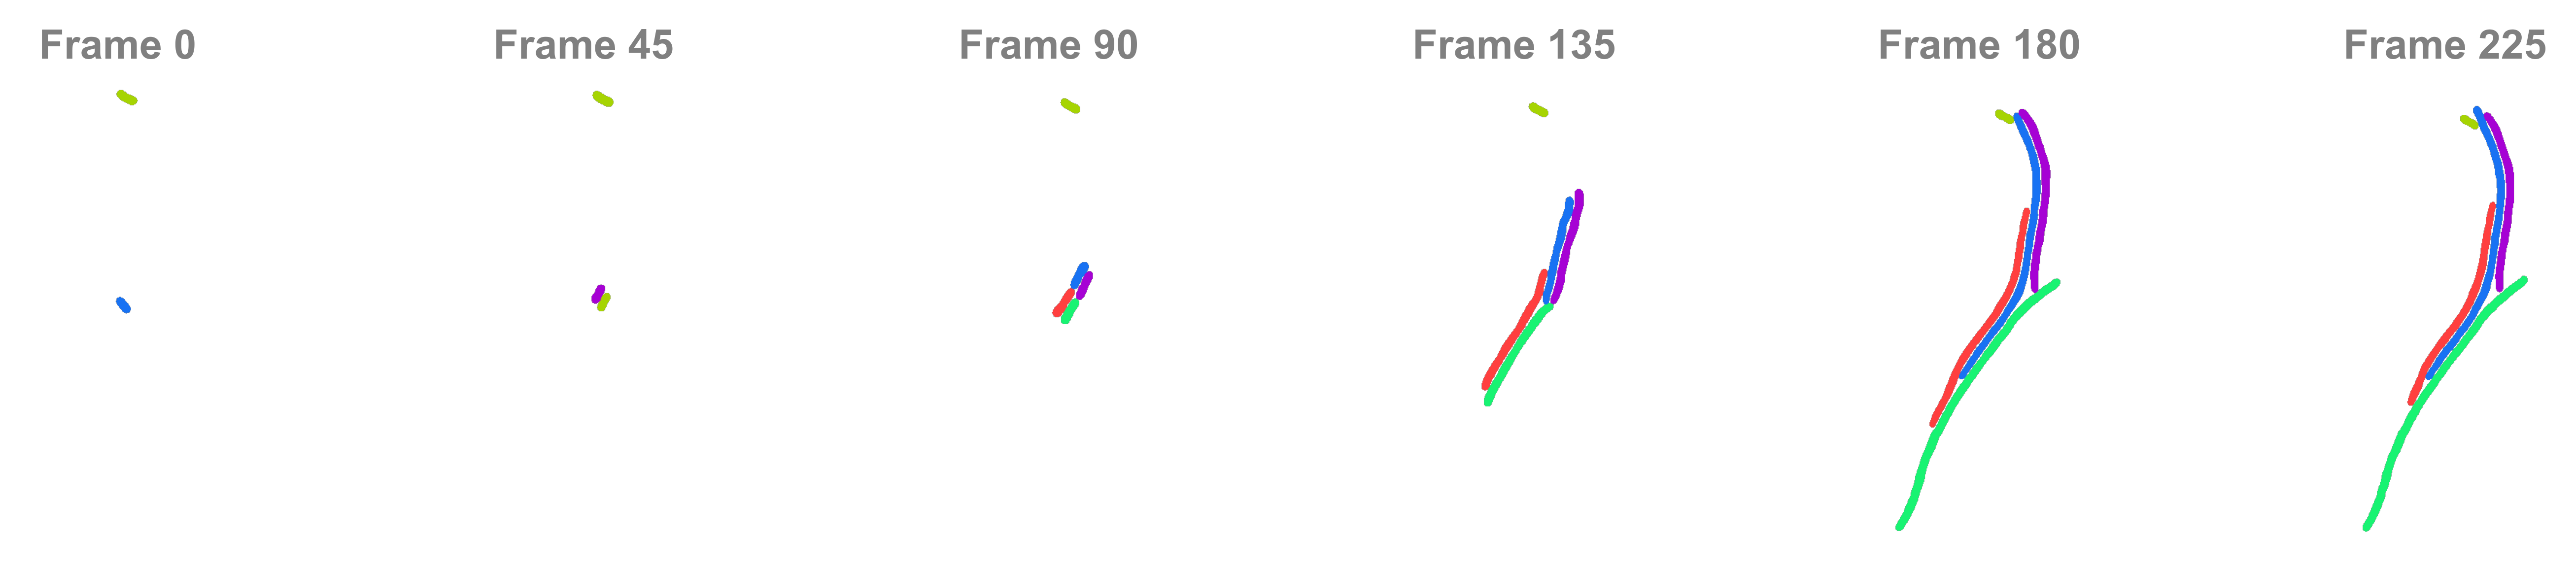

In [79]:
from pathlib import Path
from cellpose_omni import utils, plot, models, io, dynamics
import os, sys, io
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 600

# Save a reference to the original stdout stream
old_stdout = sys.stdout

# Redirect stdout to a StringIO object
sys.stdout = io.StringIO()


import omnipose
from omnipose.plot import imshow
import tifffile
omnidir = Path(omnipose.__file__).parent.parent
basedir = os.path.join(omnidir,'docs','_static')
nm = 'ftsZ'
masks = tifffile.imread(os.path.join(basedir,nm+'_masks.tif'))
mnc = omnipose.plot.apply_ncolor(masks)

f = 1
c = [0.5]*3
fontsize=10
dpi = mpl.rcParams['figure.dpi']
Y,X = masks.shape[-2:]
szX = max(X//dpi,2)*f
szY = max(Y//dpi,2)*f

# T = [50,80,100,150,180,240]
T = range(0,len(masks),45)
titles = ['Frame {}'.format(t) for t in T]
ims = [mnc[t] for t in T]
N = len(titles)

fig, axes = plt.subplots(1,N, figsize=(szX*N,szY))  
fig.patch.set_facecolor([0]*4)

for i,ax in enumerate(axes):
    ax.imshow(ims[i])
    ax.axis('off')
    ax.set_title(titles[i],c=c,fontsize=fontsize,fontweight="bold")

plt.subplots_adjust(wspace=0.1)
plt.show()

# Restore the original stdout stream
sys.stdout = old_stdout

{header-2}`Compare diameter metrics`
------------------------------------
By plotting the mean diameter (averaged over all cells after being computed per-cell, of course), we find that 
the 'circle diameter metric' used in Cellpose rises drastically with cell length, but the 'distance diameter metric' of Omnipose remains nearly constant. If we tried to use the former to train a `SizeModel()`, images would get downsampled 
heavily to the point of cells being **too thin to segment**, and that is assuming that the model can reliably detect the highly nonlocal property of cell length in an image instead of the local property of 
cell width (at least, what we humans would point to and *call* cell width). 

Of course, we also want to measure *accurate* cell widths, and it turns out that the Omnipose metric scales linearly with width perfectly spherical objects and quadratically for infinite rods. Real cells fall somewhere between these two extremes, so we have also recently developed another metric for a pill (rod with hemispherical caps) that computes the cap radius `R` and rod length `L` from the area and integrated distance field. 

Manual inspection of these masks shows that the diameter of the cells stays at a roughly constant 8px. The measured pill diameter `2R` matches well with this, and the Omnipose metric correlates well but must be corrected with a factor of 0.75 to match the absolute scale. 

Assuming the strict cell geometry bothers me, and my intuition tells me that we may yet be able to construct a morphology-independent measure of cell width from the distance field. My best attempt so far is to weight the distance field inverse to the magnitude of its gradient; this is equivalent to integrating the distance field over the skeleton / medial axis. This too gives us an accurate measure of cell width. This ends up pulling in some pixels close to the poles and is sensitive to pixelization artifacts of small cells (you can see this in the dips corresponding to division events). However, this sensitivity may actually tell us something real about the cell morphology, such as the non-circularity of the poles and the pinching of the septum. I could be convinced, for example, that this measurement really does correspond to the cells being a bit fatter at `t=0` than `t=-1`. 


In [74]:
import fastremap, edt
n = len(masks)
diam_old = np.zeros(n)
cell_num = np.zeros(n)
x = range(n)
pL = np.zeros(n)
pR = np.zeros(n)
oL = np.zeros(n)
oD = np.zeros(n)

rL = np.zeros(n)
rR = np.zeros(n)
for k in x:
    m = masks[k]
    fastremap.renumber(m,in_place=True)
    cell_num[k] = m.max()
    diam_old[k] = utils.diameters(m,omni=False)[0]
    pR[k], pL[k] = omnipose.core.diameters(m,pill=True)
    oD[k], oL[k] = omnipose.core.diameters(m,pill=False,return_length=True)

    # weight by flow magnitude 
    d = edt.edt(m)
    bin0 = m>0
    D = np.sum(d[bin0])
    dP = np.stack(np.gradient(d))
    w = np.sqrt(np.sum(dP**2,axis=0))<0.6
    rR[k] = (np.sum(w[bin0]*d[bin0])/np.sum(w[bin0]))-1
    rL[k] = (3*D - np.pi*(rR[k]**4)) / (rR[k]**3)
    

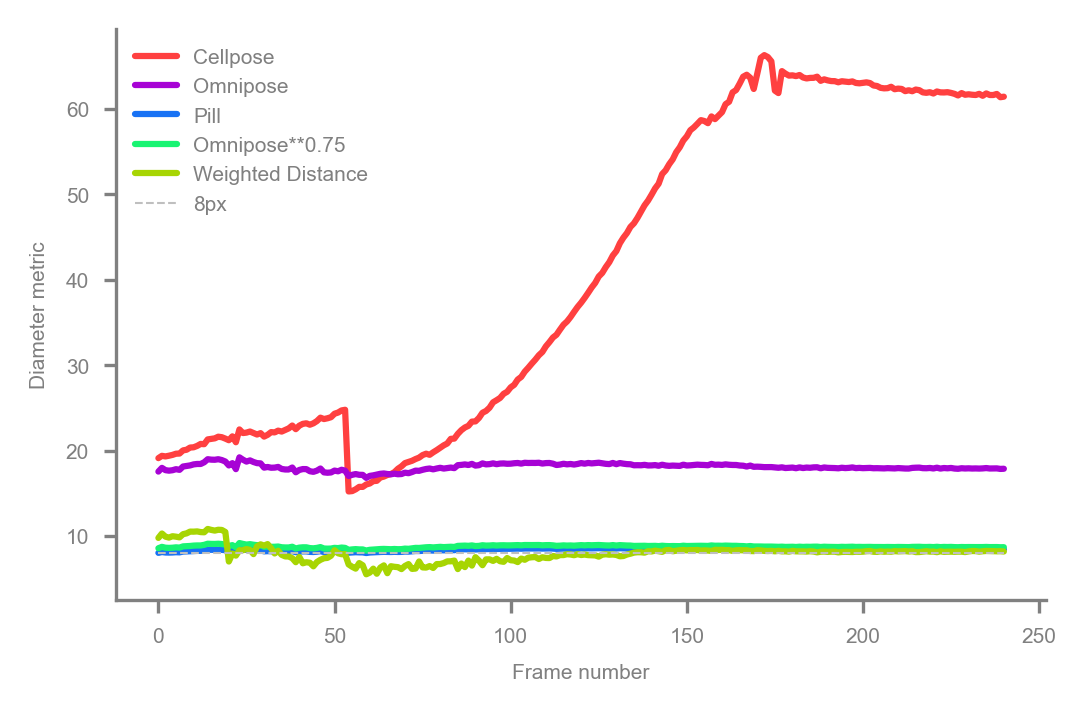

In [77]:
from omnipose.utils import sinebow
golden = (1 + 5 ** 0.5) / 2
sz = 4
labelsize = 5

%matplotlib inline

plt.style.use('dark_background')
mpl.rcParams['figure.dpi'] = 300 

axcol = [0.5]*3+[1]
f = 0.75
labels = ['Cellpose','Omnipose','Pill',f'Omnipose**{f}','Weighted Distance']
lines = [diam_old,
         oD,
         pR*2,
         oD**f,
         rR*2,
         ]

N = len(labels)
colors = sinebow(N,offset=0)
background_color = [0]*4

fig = plt.figure(figsize=(sz, sz/golden),frameon=False) 
fig.patch.set_facecolor(None)

ax = plt.axes()
maxnorm = 0
minmaxnorm = 0
log = 0
for line,label,color in zip(lines,
                            labels,
                            [colors[i+1] for i in range(N)]):
    l = line.copy()
    if maxnorm:
        l /= l.max()
    elif minmaxnorm:
        l = omnipose.utils.rescale(l)
    
    ax.plot(x,l,c=color,label=label)

ax.hlines(8,x[0],x[-1],[0.75]*3,'--',label = '8px', linewidth = 0.5)


ax.legend(loc='best', frameon=False,labelcolor=axcol, fontsize = labelsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
ax.set_ylabel('Diameter metric', fontsize = labelsize,c=axcol)
ax.set_xlabel('Frame number', fontsize = labelsize, c=axcol)
ax.set_facecolor(background_color)

for spine in ax.spines.values():
    spine.set_color(axcol)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
if log: ax.set_yscale('log')



plt.show()